
**Install requirements**

In [1]:
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110518 sha256=f988df9fd4be2132cf80ebe94446c01e7f30fc034ff615ac001f7f2106ee4d8c
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


**Import libraries**

In [0]:
import os
import logging
import copy 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torch.autograd import Function

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import VisionDataset

from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import random

####**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

DATA_DIR = 'AIML_project_dataset/dataset_2'
NUM_CLASSES = 4 

BATCH_SIZE = 256     # Batch size will be chosen through a grid search
#LR = 1e-3            # Learning rate will be chosen through a grid search

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
#WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

#NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10


####**Define Data Preprocessing**

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
 
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                  # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                  # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean, std)# Normalizes tensor with mean and standard deviation
                                        
])

# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)                                    
])

####**class Quad_Reader**

In [0]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Quad_Reader(VisionDataset):
  def __init__(self, root, split='train', transform=None, target_transform=None, loader=pil_loader):
        super(Quad_Reader, self).__init__(root, transform=transform, target_transform=target_transform)
        
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.images = self.make_dataset(DATA_DIR,self.class_to_idx)

  def _find_classes(self, dir):
        
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

  def make_dataset(self, dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    
    for target in sorted(class_to_idx.keys()):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue
        for root, dirs, _ in sorted(os.walk(d)):
            for i in sorted(dirs):
                path = os.path.join(root, i)
                item = (path, class_to_idx[target])
                images.append(item)

    return images  # contiene i path delle cartelle contenenti le quaterne. Ogni path è associato ad un'etichetta che indica la posizione dell'odd

  def __getitem__(self, index):

        quad = []
        sample_dir, label = self.images[index]
        for img in sorted(os.listdir(sample_dir)):
          image_path = os.path.join(sample_dir, img) 
          quad.append( self.loader(image_path))

        # Applies preprocessing when accessing the image
        if self.transform is not None:
          for i in range(4):
              quad[i] = self.transform(quad[i])
        if self.target_transform is not None:
            label = self.target_transform(label)

        return quad, label  

  def __len__(self):
        length = len(self.images)
        return length  

####**OOONet**

In [0]:
class ConcatLayer(Function):
    @staticmethod
    def forward(ctx, fc6_1 ,fc6_2, fc6_3 ,fc6_4):
        #print(fc6_1.shape,fc6_2.shape,fc6_3.shape,fc6_4.shape )
        concatenation = torch.stack([fc6_1, fc6_2,fc6_3,fc6_4], dim=1) # esempio (3,4) (3,4)  ---> ( 2, 3, 4 )  oppure ( 4096 )( 4096 ) --> (2,4096)
        #print("out concatenation")
        #print(concatenation.shape)
        return concatenation
        
    @staticmethod
    def backward(ctx, grad_output):
        #print("backward concatenation")
        grads = torch.unbind(grad_output,dim=1)
        """for t in grads:
         print(t.shape)"""
        #print(grad_output.shape)
        return grads


class OOONet(nn.Module):

    def __init__(self, num_classes=1000):
        super(OOONet, self).__init__()
        
        self.branch1_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),           
        )
        self.branch1_2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                   #FC 6 
            nn.ReLU(inplace=True),
        )
        self.branch2_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),
        )
        self.branch2_2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                   #FC 6 
            nn.ReLU(inplace=True),
        )
        self.branch3_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),   
        )
        self.branch3_2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                   #FC 6 
            nn.ReLU(inplace=True),
        )
        self.branch4_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  #CONV 5 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),
               
        )
        self.branch4_2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                   #FC 6 
            nn.ReLU(inplace=True),
        )        
        #self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
     
        #Livelli di fusione!!!!!!!
        self.concatLayer = ConcatLayer()

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096*4,4096),            
            nn.ReLU(inplace=True),
            nn.Linear(4096, NUM_CLASSES),
        )
        
    
    def forward(self, x):
        # X è un vettore di 4 immagini.
        x0 = self.branch1_1(x[0])
        #x0 = self.avgpool(x0)
        x0 = torch.flatten(x0, 1)
        output_branch1 = self.branch1_2(x0)

        x1 = self.branch2_1(x[1])
        #x1 = self.avgpool(x1)
        x1 = torch.flatten(x1, 1)
        output_branch2 = self.branch2_2(x1)

        x2 = self.branch3_1(x[2])
        #x2 = self.avgpool(x2)
        x2 = torch.flatten(x2, 1)
        output_branch3 = self.branch3_2(x2)

        x3 = self.branch4_1(x[3])
        #x3 = self.avgpool(x3)
        x3 = torch.flatten(x3, 1)
        output_branch4 = self.branch4_2(x3)

        out = self.concatLayer.apply(output_branch1,output_branch2,output_branch3,output_branch4) 
        out = torch.flatten(out,1)
        #print("out flatten")
        #print(out.shape)
        out = self.classifier(out)
      
        
        return out

def buildO3Net ():

    model = alexnet(pretrained=True)

    net =  OOONet()
    
    #DEEP COPY FEATURES OF BRANCH 1

    net.branch1_1[0].weight.data = copy.deepcopy(model.features[0].weight.data)
    net.branch1_1[0].bias.data = copy.deepcopy(model.features[0].bias.data)   
    net.branch1_1[3].weight.data = copy.deepcopy(model.features[3].weight.data)
    net.branch1_1[3].bias.data = copy.deepcopy(model.features[3].bias.data)
    net.branch1_1[6].weight.data = copy.deepcopy(model.features[6].weight.data)
    net.branch1_1[6].bias.data = copy.deepcopy(model.features[6].bias.data)
    net.branch1_1[8].weight.data = copy.deepcopy(model.features[8].weight.data)
    net.branch1_1[8].bias.data = copy.deepcopy(model.features[8].bias.data)
    net.branch1_1[10].weight.data = copy.deepcopy(model.features[10].weight.data)
    net.branch1_1[10].bias.data = copy.deepcopy(model.features[10].bias.data)
    net.branch1_2[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
    net.branch1_2[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)


    #DEEP COPY FEATURES OF BRANCH 2

    net.branch2_1[0].weight.data = copy.deepcopy(model.features[0].weight.data)
    net.branch2_1[0].bias.data = copy.deepcopy(model.features[0].bias.data)   
    net.branch2_1[3].weight.data = copy.deepcopy(model.features[3].weight.data)
    net.branch2_1[3].bias.data = copy.deepcopy(model.features[3].bias.data)
    net.branch2_1[6].weight.data = copy.deepcopy(model.features[6].weight.data)
    net.branch2_1[6].bias.data = copy.deepcopy(model.features[6].bias.data)
    net.branch2_1[8].weight.data = copy.deepcopy(model.features[8].weight.data)
    net.branch2_1[8].bias.data = copy.deepcopy(model.features[8].bias.data)
    net.branch2_1[10].weight.data = copy.deepcopy(model.features[10].weight.data)
    net.branch2_1[10].bias.data = copy.deepcopy(model.features[10].bias.data)
    net.branch2_2[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
    net.branch2_2[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)

    #DEEP COPY FEATURES OF BRANCH 3

    net.branch3_1[0].weight.data = copy.deepcopy(model.features[0].weight.data)
    net.branch3_1[0].bias.data = copy.deepcopy(model.features[0].bias.data)   
    net.branch3_1[3].weight.data = copy.deepcopy(model.features[3].weight.data)
    net.branch3_1[3].bias.data = copy.deepcopy(model.features[3].bias.data)
    net.branch3_1[6].weight.data = copy.deepcopy(model.features[6].weight.data)
    net.branch3_1[6].bias.data = copy.deepcopy(model.features[6].bias.data)
    net.branch3_1[8].weight.data = copy.deepcopy(model.features[8].weight.data)
    net.branch3_1[8].bias.data = copy.deepcopy(model.features[8].bias.data)
    net.branch3_1[10].weight.data = copy.deepcopy(model.features[10].weight.data)
    net.branch3_1[10].bias.data = copy.deepcopy(model.features[10].bias.data)
    net.branch3_2[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
    net.branch3_2[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)

    #DEEP COPY FEATURES OF BRANCH 4

    net.branch4_1[0].weight.data = copy.deepcopy(model.features[0].weight.data)
    net.branch4_1[0].bias.data = copy.deepcopy(model.features[0].bias.data)   
    net.branch4_1[3].weight.data = copy.deepcopy(model.features[3].weight.data)
    net.branch4_1[3].bias.data = copy.deepcopy(model.features[3].bias.data)
    net.branch4_1[6].weight.data = copy.deepcopy(model.features[6].weight.data)
    net.branch4_1[6].bias.data = copy.deepcopy(model.features[6].bias.data)
    net.branch4_1[8].weight.data = copy.deepcopy(model.features[8].weight.data)
    net.branch4_1[8].bias.data = copy.deepcopy(model.features[8].bias.data)
    net.branch4_1[10].weight.data = copy.deepcopy(model.features[10].weight.data)
    net.branch4_1[10].bias.data = copy.deepcopy(model.features[10].bias.data)
    net.branch4_2[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
    net.branch4_2[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)

    return net



####**Prepare Dataset**

In [8]:
# Clone github repository with data
if not os.path.isdir('./AIML_project_dataset'):
  !git clone https://github.com/rebeccapelaca/AIML_project_dataset.git

dataset = Quad_Reader(DATA_DIR, transform=train_transform)
print('Dataset: {}'.format(len(dataset)))
"""
# 33 - 33- 33
train_indexes = [idx for idx in range(len(dataset)) if (idx % 3) == 1]
val_indexes = [idx for idx in range(len(dataset)) if (idx % 3) == 2]
test_indexes = [idx for idx in range(len(dataset)) if not (idx % 3)]
"""

# 60 - 20 - 20

train_indexes = [idx for idx in range(len(dataset)) if (idx % 3) != 0]
val_indexes = [idx for idx in range(len(dataset)) if (idx % 3) == 0 and (idx % 6) != 0]
test_indexes = [idx for idx in range(len(dataset)) if not (idx % 6)]

"""
# 50 - 30 -20

train_indexes = [idx for idx in range(len(dataset)) if (idx % 2) != 0]
val_indexes = [idx for idx in range(len(dataset)) if (idx % 2) == 0 and (idx % 6) != 0]
test_indexes = [idx for idx in range(len(dataset)) if not (idx % 6)]
"""

train_dataset = Subset(dataset, train_indexes)
val_dataset = Subset(dataset, val_indexes)
test_dataset = Subset(dataset, test_indexes)

print('Training Dataset: {}'.format(len(train_dataset)))
print('Validation Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))


Dataset: 14064
Training Dataset: 9376
Validation Dataset: 2344
Test Dataset: 2344


####**Dataloaders**

In [0]:
"""train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)"""

###**Random Search**

In [0]:

def plot_graph(epoches ,val_data , train_data, lr,wd,dp ,xlabel ,ylabel, legend1 = "val", legend2="train"):
  
  epoches = range(epoches)
  plt.plot(epoches,val_data,label=legend1)
  plt.plot(epoches,train_data,label=legend2)
  
  plt.title('Hyperparameters - LR={} WD={} DP={}'.format(lr,wd,dp))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show() 


In [0]:
#parametri
best_LR = 0
best_BS = 0
best_WD = 0
best_DP = 0
bss = [128,256]
num_iters = 3
best_acc = 0.0

for bs in bss:
  train_dataloader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
  val_dataloader = DataLoader(dataset=val_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
  
  for iteration in range(num_iters):

    # Pick random hyperparameters in a specified range
    mod = random.randint(1,9)
    lr = mod*10**(-random.randint(2,4)) #learning rate 
    wd = 10**(-random.randint(4,6)) #weight_decay
    dp = random.uniform(0.2,0.5)    #dropout probability

    net = buildO3Net()
    net.to(DEVICE)

    net.branch1_2[0] = nn.Dropout(dp)
    net.branch2_2[0] = nn.Dropout(dp)
    net.branch3_2[0] = nn.Dropout(dp)
    net.branch4_2[0] = nn.Dropout(dp)
    net.classifier[0] = nn.Dropout(dp)  

    criterion = nn.CrossEntropyLoss() 
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    num_epochs = 30

    current_step=0
    tmp_accuracy = 0.0
    current_step = 0

    val_acc_history_1 = []
    val_loss_history_1 = []
    train_acc_history_1 = []
    train_loss_history_1 = []
    test_accuracy_local = 0 # best accuracy for one set of parameters
    lossNan = False
    for epoch in range(num_epochs):
      
      running_loss_1 = 0.0
      running_corrects_1 = 0
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

      for images, labels in train_dataloader:

        for i in range(4):
          images[i] = images[i].to(DEVICE)
        
        labels = labels.to(DEVICE)

        net.train() 

        optimizer.zero_grad() # Zero-ing the gradients
        
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        print("loss:{}".format(loss.item()))

        if np.isnan(loss.item()):
          lossNan = True
          print("Early stopping: loss NaN")
          break

        loss.backward()  
        optimizer.step() 

        running_loss_1 += loss.item() 
        running_corrects_1 += torch.sum(preds == labels.data)
                                        
        current_step += 1
      
      #statistiche
      epoch_loss_1 = running_loss_1 / len(train_dataloader)
      epoch_acc_1 = running_corrects_1 / float(len(train_dataloader.dataset))
      train_loss_history_1.append(epoch_loss_1)              
      train_acc_history_1.append(epoch_acc_1)

      if lossNan:
        break

      net.to(DEVICE)
      net.train(False) # Set Network to evaluation mode

      running_corrects_1 = 0.0
      running_loss_1 = 0.0
      
      for images, labels in tqdm(val_dataloader):
        
        for i in range(4):
          images[i] = images[i].to(DEVICE)

        labels = labels.to(DEVICE)
        # Forward Pass
        outputs = net(images)
        loss = criterion(outputs,labels)
        _, preds = torch.max(outputs.data, 1)
        
        # statistics
        running_loss_1 += loss.item() 
        running_corrects_1 += torch.sum(preds == labels.data).data.item()

      # Calculate Accuracy
      test_accuracy = running_corrects_1 / float(len(val_dataloader.dataset))  
      print('Test Accuracy: {}'.format(test_accuracy))
      if test_accuracy > test_accuracy_local:
        test_accuracy_local = test_accuracy

      
      epoch_loss_1 = running_loss_1 / len(val_dataloader)           
  
      val_loss_history_1.append(epoch_loss_1)              
      val_acc_history_1.append(test_accuracy)

      # Step the scheduler
      scheduler.step() 

    if lossNan == False:
      if test_accuracy_local > best_acc:
        best_acc = test_accuracy_local 
        best_LR = lr
        best_WD = wd
        best_DP = dp
        best_BS = bs

      #plot graphs
      plot_graph(num_epochs , val_loss_history_1 ,train_loss_history_1 ,lr,wd,dp ,"epochs" ,"loss", "val","train")
      plot_graph(num_epochs , val_acc_history_1, train_acc_history_1  ,lr,wd,dp ,"epochs" ,"accuracy", "val","train")
      
print('find_best_HyperParam_3B COMPLETE ')
print("Best hyperparameters: best accuracy:{}, best_LR:{}, best_WD:{}, best_DP:{}, best_BS:{}".format(best_acc,best_LR,best_WD,best_DP,best_BS))

Starting epoch 1/30, LR = [0.05]
loss:1.532785415649414
loss:27.712663650512695
loss:131.1982421875
loss:185324.84375
loss:3.1046332457964934e+21
loss:nan
Early stopping: loss NaN
Starting epoch 1/30, LR = [0.0008]
loss:1.7146010398864746
loss:1.4615944623947144
loss:1.5863054990768433
loss:1.6538290977478027
loss:1.4451688528060913
loss:1.469068169593811
loss:1.7209364175796509
loss:1.6293708086013794
loss:1.5429500341415405
loss:1.7913789749145508
loss:1.6388576030731201
loss:1.550911784172058
loss:1.6055102348327637
loss:1.661488652229309
loss:1.4436198472976685
loss:1.4173388481140137
loss:1.5877916812896729
loss:1.4579849243164062
loss:1.4928725957870483
loss:1.4714106321334839
loss:1.497873067855835
loss:1.4971375465393066
loss:1.4358760118484497
loss:1.3761247396469116
loss:1.4137152433395386
loss:1.4239122867584229
loss:1.4715300798416138
loss:1.3658766746520996
loss:1.296309471130371
loss:1.4064600467681885
loss:1.3632389307022095
loss:1.4124228954315186
loss:1.390907406806945

100%|██████████| 18/18 [00:11<00:00,  2.26it/s]

Test Accuracy: 0.5951365187713311
Starting epoch 2/30, LR = [0.0008]


loss:1.2229915857315063
loss:1.1584490537643433
loss:1.1321320533752441
loss:1.2065403461456299
loss:1.0407921075820923
loss:1.1014068126678467
loss:1.2337772846221924
loss:1.1889311075210571
loss:1.0986683368682861
loss:1.1671350002288818
loss:1.1888301372528076
loss:1.1620097160339355
loss:1.1033334732055664
loss:1.2049801349639893
loss:1.0750504732131958
loss:1.1548463106155396
loss:1.1115552186965942
loss:1.1496970653533936
loss:1.1338980197906494
loss:1.0805976390838623
loss:1.202216625213623
loss:1.077813982963562
loss:1.1164497137069702
loss:0.9810262322425842
loss:1.1338211297988892
loss:1.119981050491333
loss:1.15022873878479
loss:1.1118555068969727
loss:1.1306451559066772
loss:1.0615131855010986
loss:1.180680751800537
loss:1.0069414377212524
loss:1.0135010480880737
loss:1.1132410764694214
loss:1.2030658721923828
loss:1.1290626525878906
loss:1.1143929958343506
loss:1.0622766017913818
loss:1.0388133525848389
loss:1.057808756828308
loss:1.05678391456604
loss:1.0894800424575806
l

100%|██████████| 18/18 [00:11<00:00,  2.32it/s]

Test Accuracy: 0.8003412969283277
Starting epoch 3/30, LR = [0.0008]


loss:0.8792366981506348
loss:0.7327929735183716
loss:0.7376910448074341
loss:0.7851918339729309
loss:0.9070088267326355
loss:0.81095290184021
loss:0.7405819892883301
loss:0.8561370372772217
loss:0.7558890581130981
loss:0.6879646182060242
loss:0.6754375100135803
loss:0.683413028717041
loss:0.7530062794685364
loss:0.7999445796012878
loss:0.7890557050704956
loss:0.673642098903656
loss:0.7808150053024292
loss:0.6930979490280151
loss:0.761551022529602
loss:0.7389392852783203
loss:0.6220166683197021
loss:0.7537626624107361
loss:0.6400910019874573
loss:0.6699990630149841
loss:0.7942867875099182
loss:0.6828997731208801
loss:0.8220833539962769
loss:0.8102007508277893
loss:0.6994004845619202
loss:0.6831294298171997
loss:0.7285158038139343
loss:0.8051027059555054
loss:0.6876522302627563
loss:0.6950526237487793
loss:0.7343114018440247
loss:0.6324892640113831
loss:0.7670414447784424
loss:0.7808434963226318
loss:0.7846797108650208
loss:0.6644756197929382
loss:0.6868113279342651
loss:0.81378459930419

100%|██████████| 18/18 [00:10<00:00,  2.40it/s]

Test Accuracy: 0.8732935153583617
Starting epoch 4/30, LR = [0.0008]


loss:0.5122994184494019
loss:0.49938082695007324
loss:0.4203847050666809
loss:0.479666143655777
loss:0.419553279876709
loss:0.42019885778427124
loss:0.5006558299064636
loss:0.5198125839233398
loss:0.4648001492023468
loss:0.43637949228286743
loss:0.49803626537323
loss:0.45201748609542847
loss:0.430569052696228
loss:0.3953244388103485
loss:0.4924016296863556
loss:0.41175153851509094
loss:0.3894549608230591
loss:0.5473706722259521
loss:0.47462281584739685
loss:0.5488937497138977
loss:0.5138311982154846
loss:0.5023368000984192
loss:0.4415833055973053
loss:0.29574260115623474
loss:0.4254618287086487
loss:0.4877487123012543
loss:0.4360063076019287
loss:0.5242510437965393
loss:0.45383593440055847
loss:0.45277687907218933
loss:0.381662517786026
loss:0.44258004426956177
loss:0.45543891191482544
loss:0.4720405340194702
loss:0.4482995569705963
loss:0.5207499265670776
loss:0.4723023474216461
loss:0.5043080449104309
loss:0.44441652297973633
loss:0.49728867411613464
loss:0.4671397805213928
loss:0.47

100%|██████████| 18/18 [00:11<00:00,  2.19it/s]

Test Accuracy: 0.9159556313993175
Starting epoch 5/30, LR = [0.0008]


loss:0.28972455859184265
loss:0.2922218143939972
loss:0.3573829233646393
loss:0.2640579044818878
loss:0.2223823070526123
loss:0.2585209012031555
loss:0.2262527495622635
loss:0.3715594708919525
loss:0.21681585907936096
loss:0.32657989859580994
loss:0.355377197265625
loss:0.28937602043151855
loss:0.25666573643684387
loss:0.3024802505970001
loss:0.30871638655662537
loss:0.23254963755607605
loss:0.2900795042514801
loss:0.29400140047073364
loss:0.336869478225708
loss:0.27624234557151794
loss:0.22408610582351685
loss:0.2688593864440918
loss:0.34433451294898987
loss:0.27712780237197876
loss:0.2890200614929199
loss:0.33414870500564575
loss:0.2818957567214966
loss:0.24499128758907318
loss:0.3085448741912842
loss:0.35900139808654785
loss:0.2923734188079834
loss:0.30864217877388
loss:0.2517862021923065
loss:0.33076682686805725
loss:0.17547734081745148
loss:0.30516910552978516
loss:0.22807635366916656
loss:0.25227147340774536
loss:0.3236572742462158
loss:0.3136660158634186
loss:0.32548603415489197

100%|██████████| 18/18 [00:10<00:00,  2.27it/s]

Test Accuracy: 0.9641638225255973
Starting epoch 6/30, LR = [0.0008]


loss:0.19201572239398956
loss:0.1555376946926117
loss:0.2206641435623169
loss:0.18199342489242554
loss:0.16569970548152924
loss:0.16725952923297882
loss:0.22717617452144623
loss:0.18060070276260376
loss:0.2788238823413849
loss:0.18443793058395386
loss:0.24548377096652985
loss:0.189088374376297
loss:0.17964334785938263
loss:0.23089595139026642
loss:0.17861242592334747
loss:0.21742653846740723
loss:0.23847831785678864
loss:0.19412176311016083
loss:0.15066730976104736
loss:0.14929673075675964
loss:0.17708735167980194
loss:0.2618626654148102
loss:0.2145494520664215
loss:0.19108034670352936
loss:0.2226320058107376
loss:0.15284864604473114
loss:0.2827070951461792
loss:0.2549976110458374
loss:0.2375645637512207
loss:0.16391488909721375
loss:0.2462776154279709
loss:0.22773998975753784
loss:0.2274327576160431
loss:0.15220771729946136
loss:0.26736122369766235
loss:0.2853582203388214
loss:0.16818392276763916
loss:0.30606532096862793
loss:0.2737385928630829
loss:0.1884736716747284
loss:0.225192874

100%|██████████| 18/18 [00:11<00:00,  2.35it/s]

Test Accuracy: 0.9735494880546075
Starting epoch 7/30, LR = [0.0008]


loss:0.2065015286207199
loss:0.10220851749181747
loss:0.13881534337997437
loss:0.1917501986026764
loss:0.1317654699087143
loss:0.14316369593143463
loss:0.14732763171195984
loss:0.09844618290662766
loss:0.16688677668571472
loss:0.12806764245033264
loss:0.18758605420589447
loss:0.15719196200370789
loss:0.1857345700263977
loss:0.1422090232372284
loss:0.15196667611598969
loss:0.1809718757867813
loss:0.2054997682571411
loss:0.19685277342796326
loss:0.18155789375305176
loss:0.1410679668188095
loss:0.20410284399986267
loss:0.19257910549640656
loss:0.21024657785892487
loss:0.14077365398406982
loss:0.1440911889076233
loss:0.1724962741136551
loss:0.21399223804473877
loss:0.2014855593442917
loss:0.1278335005044937
loss:0.1457485556602478
loss:0.13824139535427094
loss:0.1769476681947708
loss:0.18365100026130676
loss:0.1447143852710724
loss:0.1381816864013672
loss:0.12473342567682266
loss:0.21344193816184998
loss:0.1400001496076584
loss:0.17680539190769196
loss:0.23270060122013092
loss:0.1994219124

100%|██████████| 18/18 [00:10<00:00,  2.65it/s]

Test Accuracy: 0.9761092150170648
Starting epoch 8/30, LR = [0.0008]


loss:0.10322364419698715
loss:0.1261044442653656
loss:0.09152843803167343
loss:0.06757625937461853
loss:0.07162711024284363
loss:0.09888184815645218
loss:0.09051831066608429
loss:0.1517295092344284
loss:0.1419079601764679
loss:0.13171635568141937
loss:0.06070072948932648
loss:0.10827790200710297
loss:0.12727834284305573
loss:0.058976609259843826
loss:0.07523733377456665
loss:0.09160687029361725
loss:0.09145216643810272
loss:0.0854407250881195
loss:0.08666486293077469
loss:0.16084004938602448
loss:0.07113217562437057
loss:0.16034013032913208
loss:0.12243055552244186
loss:0.10121473670005798
loss:0.0971083790063858
loss:0.10878345370292664
loss:0.18885104358196259
loss:0.08328499644994736
loss:0.0844692662358284
loss:0.09577079117298126
loss:0.11213092505931854
loss:0.06094929948449135
loss:0.10970088094472885
loss:0.0799732431769371
loss:0.10079137980937958
loss:0.06206641346216202
loss:0.07327061891555786
loss:0.13015617430210114
loss:0.07633888721466064
loss:0.049511924386024475
loss:

100%|██████████| 18/18 [00:10<00:00,  2.52it/s]

Test Accuracy: 0.98080204778157
Starting epoch 9/30, LR = [0.0008]


loss:0.11336503177881241
loss:0.03758329153060913
loss:0.07594017684459686
loss:0.04481671005487442
loss:0.0738774985074997
loss:0.05142008513212204
loss:0.1259058713912964
loss:0.09305243194103241
loss:0.07981046289205551
loss:0.07924024015665054
loss:0.0564175620675087
loss:0.11370458453893661
loss:0.11188793927431107
loss:0.11435090005397797
loss:0.1001112163066864
loss:0.06017822027206421
loss:0.06264504790306091
loss:0.11324870586395264
loss:0.04544677212834358
loss:0.07328370213508606
loss:0.08383718132972717
loss:0.1039125844836235
loss:0.046214424073696136
loss:0.09211651235818863
loss:0.06644844263792038
loss:0.0708589255809784
loss:0.09048223495483398
loss:0.07581500709056854
loss:0.1499626338481903
loss:0.09094786643981934
loss:0.1085384413599968
loss:0.03429252654314041
loss:0.05450097471475601
loss:0.07431385666131973
loss:0.0773073360323906
loss:0.11107154190540314
loss:0.061624351888895035
loss:0.08971748501062393
loss:0.0855017676949501
loss:0.04792565852403641
loss:0.0

100%|██████████| 18/18 [00:10<00:00,  2.40it/s]

Test Accuracy: 0.981655290102389
Starting epoch 10/30, LR = [0.0008]


loss:0.055507078766822815
loss:0.0819244533777237
loss:0.09904173761606216
loss:0.055343687534332275
loss:0.04365178197622299
loss:0.0410594679415226
loss:0.05664528161287308
loss:0.04190966486930847
loss:0.052646853029727936
loss:0.051727838814258575
loss:0.10280703008174896
loss:0.1333703249692917
loss:0.02875448949635029
loss:0.04934391751885414


####**Train**

In [15]:
print("Best hyperparameters: best accuracy:{}, best_LR:{}, best_WD:{}, best_DP:{}".format(best_acc,best_LR,best_WD,best_DP))
net = buildO3Net()
net.to(DEVICE)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=best_LR, momentum=MOMENTUM, weight_decay=best_WD)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net.branch1_2[0] = nn.Dropout(best_DP)
net.branch2_2[0] = nn.Dropout(best_DP)
net.branch3_2[0] = nn.Dropout(best_DP)
net.branch4_2[0] = nn.Dropout(best_DP)
net.classifier[0] = nn.Dropout(best_DP)

# TODO (da fare meglio) training su training + validation
train_indexes = [idx for idx in range(len(dataset)) if (idx % 6) != 0]
train_dataset = Subset(dataset, train_indexes)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=4, drop_last=True)

num_epochs = 30
current_step=0
for epoch in range(num_epochs):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

    for images, labels in train_dataloader:

      for i in range(4):
        images[i] = images[i].to(DEVICE)
      
      labels = labels.to(DEVICE)

      net.train() 

      optimizer.zero_grad() 
      
      outputs = net(images)

      loss = criterion(outputs, labels)
      print("loss:{}".format(loss.item()))

      loss.backward()  
      optimizer.step() 

      current_step += 1



Best hyperparameters: best accuracy:0.8336177474402731, best_LR:0.005, best_WD:1e-05, best_DP:0.41025340676345634
Starting epoch 1/30, LR = [0.005]
loss:1.601827621459961
loss:3.2940492630004883
loss:4.284773349761963
loss:6.182133197784424
loss:4.94054651260376
loss:2.606320858001709
loss:1.7988625764846802
loss:1.590193271636963
loss:1.5583510398864746
loss:1.5048937797546387
loss:1.4555134773254395
loss:1.461142659187317
loss:1.4298733472824097
loss:1.4230691194534302
loss:1.4009038209915161
loss:1.3930063247680664
loss:1.3983542919158936
loss:1.3858470916748047
loss:1.3896163702011108
loss:1.3912909030914307
loss:1.3939672708511353
loss:1.388340711593628
loss:1.384264349937439
loss:1.389038324356079
loss:1.3905233144760132
loss:1.386885404586792
loss:1.3836426734924316
loss:1.3873050212860107
loss:1.3885078430175781
loss:1.3836308717727661
loss:1.383281946182251
loss:1.3874989748001099
loss:1.385715126991272
loss:1.3842581510543823
loss:1.38396418094635
loss:1.3863880634307861
loss

###**Test**

In [16]:
#net = net.to(DEVICE) 
net.train(False) # Set Network to evaluation mode , equivalent to net.eval()

test_dataloader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=True, num_workers=4, drop_last=True)

running_corrects = 0
for images, labels in tqdm(test_dataloader): #evaluate performance on validation set
  for i in range(4):
      images[i] = images[i].to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)
  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy on validation set
accuracy = running_corrects / float(len(test_dataset))


print('Test Accuracy: {}'.format(accuracy))



100%|██████████| 9/9 [00:15<00:00,  1.63s/it]

Test Accuracy: 0.9180887372013652


####**Data examples**
Print some of the results.

In [0]:
num_img=10
saved_outputs = torch.Tensor([256,4])
saved_labels = torch.Tensor([256])
saved_images = torch.Tensor([])

def imshow(inp,ax, title=None):

    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)

def visualize(net, dataloader, num):
 
  net.train(False)
  fig = plt.figure(figsize=(15,7))
  images_so_far = 0

  for images,labels in dataloader:
    saved_labels = labels
    for i in range(4):
      images[i] = images[i].to(DEVICE)
    
    labels = labels.to(DEVICE)

    outputs = net(images)
    saved_outputs = outputs
    
    _, preds = torch.max(outputs.data, 1)

    for j in range(256):
      # uncomment the following line to print mislabeled images only
      #if dataset.classes[preds[j]] != dataset.classes[labels[j]]:       
        images_so_far += 1
        k=1
        fig = plt.figure(figsize=(11,2))
        for i in range (4) :
          #ax = plt.subplot(1,4,k)
          ax = fig.add_subplot(1,4,i+1)
          ax.axis('off')
          k += 1
          imshow(images[i].cpu().data[j],ax) #
        fig.suptitle('predicted: {} - real: {}'.format(dataset.classes[preds[j]],dataset.classes[labels[j]]))
        plt.show()
        print("\n")
        if images_so_far == num:
          return

<Figure size 1080x504 with 0 Axes>

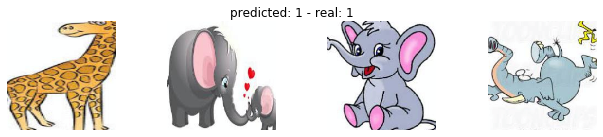

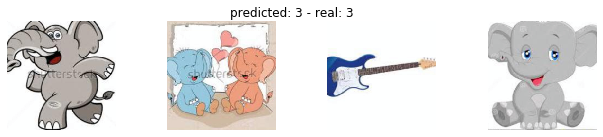

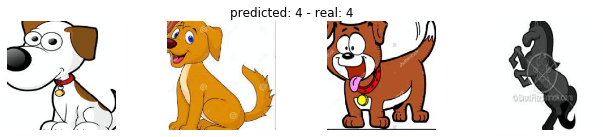

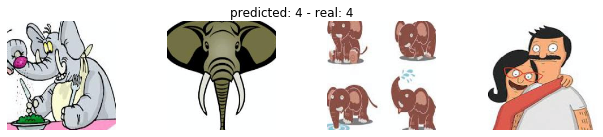

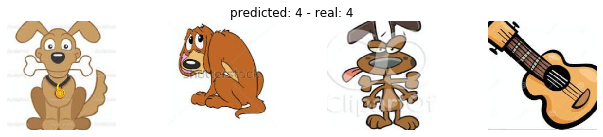

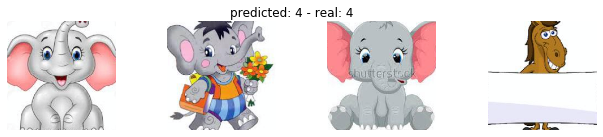

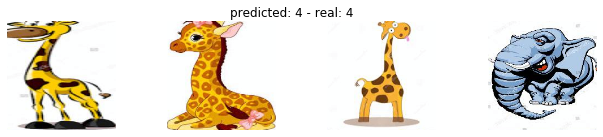

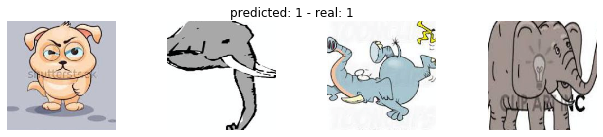

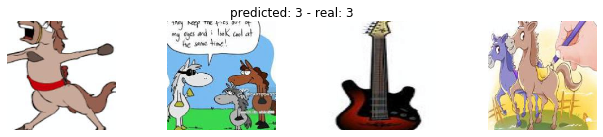

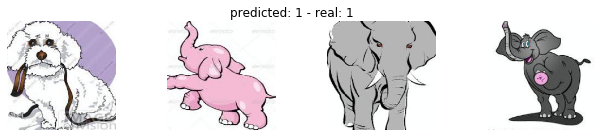

In [23]:
tot_dataloader = DataLoader(dataset=dataset, batch_size=256, shuffle=True, num_workers=4, drop_last=True)
visualize(net,tot_dataloader,num_img)